## Part 1: Supervised Baseline (Feedforward Network)
**Project**: FraudGuard - Credit Card Fraud Detection 

**Goal**: Establish a strong supervised benchmark using Weighted Loss and Threshold Optimization.

## 1. Setup and Exploratory Data Analysis (EDA)
**Objective**: Understand the data distribution and justify preprocessing decisions.

Using device: cpu
Dataset Loaded. Shape: (284807, 31)


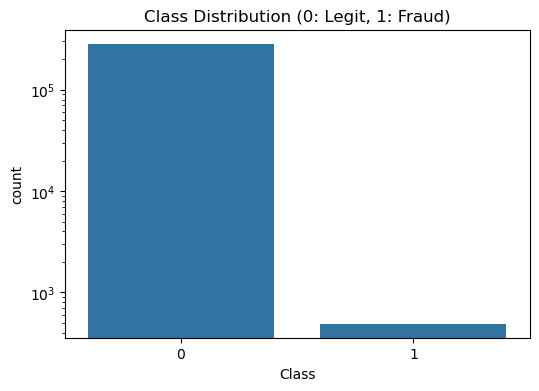

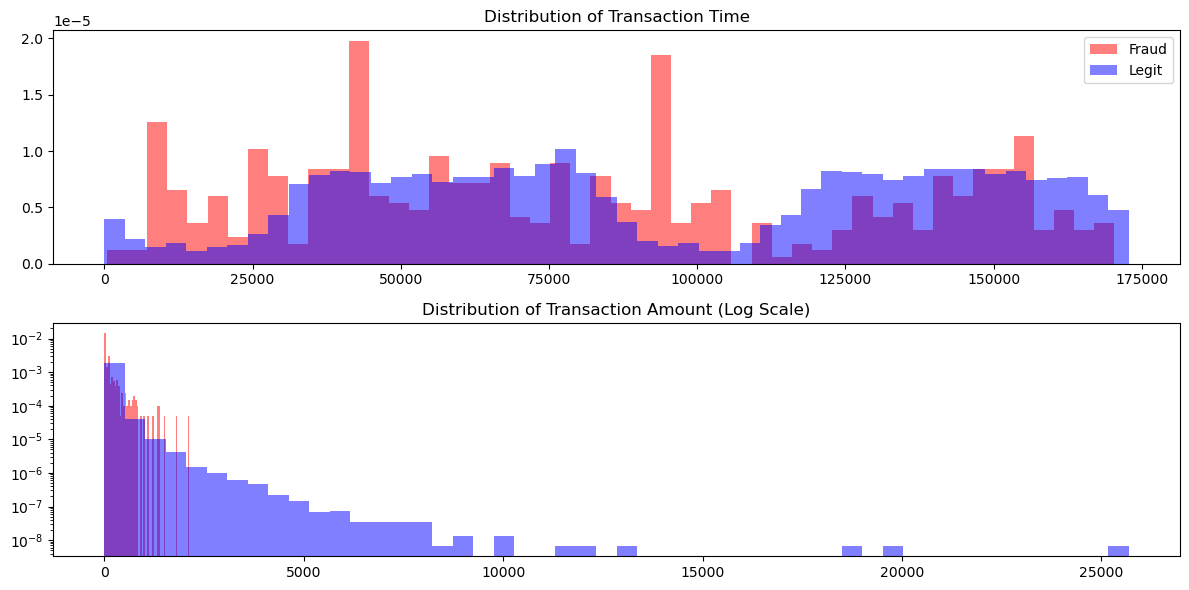

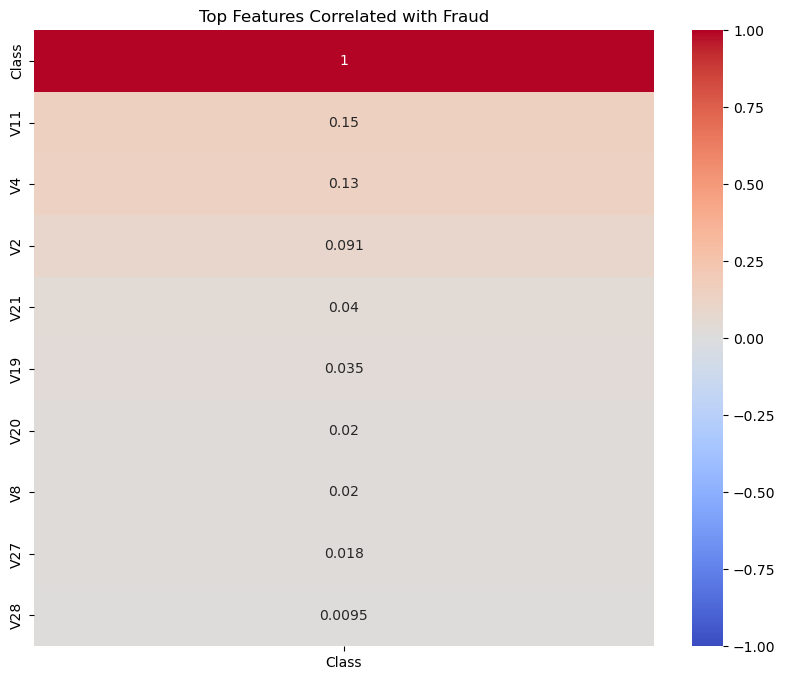

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Load Data ---
try:
    df = pd.read_csv('creditcard.csv')
    print(f"Dataset Loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found.")

# --- 2. EDA: Class Imbalance ---
# Rationale: Visualizing the <0.2% fraud rate to justify Weighted Loss.
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Legit, 1: Fraud)')
plt.yscale('log') # Log scale is crucial here
plt.show()

# --- 3. EDA: Feature Distributions ---
# Rationale: Checking if 'Time' and 'Amount' need scaling.
f, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(12, 6))
bins = 50

ax1.hist(df.Time[df.Class == 1], bins=bins, color='red', alpha=0.5, density=True, label='Fraud')
ax1.hist(df.Time[df.Class == 0], bins=bins, color='blue', alpha=0.5, density=True, label='Legit')
ax1.set_title('Distribution of Transaction Time')
ax1.legend()

ax2.hist(df.Amount[df.Class == 1], bins=bins, color='red', alpha=0.5, density=True, label='Fraud')
ax2.hist(df.Amount[df.Class == 0], bins=bins, color='blue', alpha=0.5, density=True, label='Legit')
ax2.set_title('Distribution of Transaction Amount (Log Scale)')
ax2.set_yscale('log')
plt.tight_layout()
plt.show()

# --- 4. EDA: Correlation ---
# Rationale: Identifying top predictors among PCA features.
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr[['Class']].sort_values(by='Class', ascending=False).head(10), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Top Features Correlated with Fraud')
plt.show()

## 2. Preprocessing & Data Pipeline
**Objective**: Scale features, split data, and create PyTorch Loaders.

In [14]:
# --- 1. Feature Scaling ---
# Based on EDA, Time and Amount have very different ranges than V1-V28.
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# --- 2. Stratified Split ---
# Stratify is required to keep the fraud ratio consistent in Train/Val.
X = df.drop('Class', axis=1).values
y = df['Class'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 3. PyTorch Dataset & Loaders ---
class FraudDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 64
train_dataset = FraudDataset(X_train, y_train)
val_dataset = FraudDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Data Pipeline Ready.")

Data Pipeline Ready.


## 3. Model A: Basic Baseline
**Objective**: Establish initial performance with a standard FCN.

In [15]:
# --- Architecture A: Basic FCN ---
class FraudFCN(nn.Module):
    def __init__(self, input_dim):
        super(FraudFCN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# --- Training Helper Function (To avoid code repetition) ---
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    loss_history = []
    
    print(f"Training {model.__class__.__name__}...")
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")
    return loss_history

# --- Execution ---
input_dim = X_train.shape[1]
model_basic = FraudFCN(input_dim).to(device)

# Calculate Weight for Imbalance
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
pos_weight = torch.tensor([num_neg / num_pos], device=device)
print(f"Using Positive Class Weight: {pos_weight.item():.2f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model_basic.parameters(), lr=0.001)

# Train Basic Model
basic_losses = train_model(model_basic, train_loader, criterion, optimizer, epochs=10)

# Evaluate Basic Model (Threshold 0.5)
model_basic.eval()
y_true, y_pred_basic = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        probs = torch.sigmoid(model_basic(inputs))
        y_true.extend(labels.cpu().numpy())
        y_pred_basic.extend((probs > 0.5).float().cpu().numpy())

print("\n--- Basic Model Results (Threshold 0.5) ---")
print(classification_report(y_true, y_pred_basic, target_names=['Legit', 'Fraud']))

Using Positive Class Weight: 577.29
Training FraudFCN...
Epoch [1/10] Loss: 0.5913
Epoch [2/10] Loss: 0.3246
Epoch [3/10] Loss: 0.2992
Epoch [4/10] Loss: 0.3225
Epoch [5/10] Loss: 0.2460
Epoch [6/10] Loss: 0.2383
Epoch [7/10] Loss: 0.2156
Epoch [8/10] Loss: 0.2184
Epoch [9/10] Loss: 0.1957
Epoch [10/10] Loss: 0.2017

--- Basic Model Results (Threshold 0.5) ---
              precision    recall  f1-score   support

       Legit       1.00      0.99      0.99     56864
       Fraud       0.11      0.91      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.95      0.59     56962
weighted avg       1.00      0.99      0.99     56962



## 4. Model B: Improved Architecture
**Objective**: Improve stability using Batch Normalization.

In [20]:
# --- Architecture B: Improved FCN (Batch Norm) ---
class ImprovedFraudFCN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedFraudFCN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),  # Stabilizes learning
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),  # Stabilizes learning
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# --- Training with Early Stopping ---
model_improved = ImprovedFraudFCN(input_dim).to(device)
optimizer = optim.Adam(model_improved.parameters(), lr=0.001)
# Note: Reuse 'criterion' as it contains the class weights

EPOCHS = 20
best_val_loss = float('inf')
patience = 5
trigger_times = 0
train_losses, val_losses = [], []

print("\nStarting Improved Training...")
for epoch in range(EPOCHS):
    # Train
    model_improved.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model_improved(inputs), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    
    # Validate
    model_improved.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            loss = criterion(model_improved(inputs), labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] Train: {train_losses[-1]:.4f} | Val: {avg_val_loss:.4f}")

# Load Best Weights
model_improved.load_state_dict(torch.load('best_model.pth'))


Starting Improved Training...
Epoch [1/20] Train: 0.4620 | Val: 0.3019
Epoch [2/20] Train: 0.3570 | Val: 0.2647
Epoch [3/20] Train: 0.3312 | Val: 0.2792
Epoch [4/20] Train: 0.3048 | Val: 0.2763
Epoch [5/20] Train: 0.2980 | Val: 0.2884
Epoch [6/20] Train: 0.2504 | Val: 0.3265
Epoch [7/20] Train: 0.2454 | Val: 0.2829
Epoch [8/20] Train: 0.2441 | Val: 0.3202
Epoch [9/20] Train: 0.2366 | Val: 0.2916
Epoch [10/20] Train: 0.2346 | Val: 0.3011
Epoch [11/20] Train: 0.2226 | Val: 0.3251
Epoch [12/20] Train: 0.2122 | Val: 0.3213
Epoch [13/20] Train: 0.2255 | Val: 0.3623
Epoch [14/20] Train: 0.1896 | Val: 0.3910
Epoch [15/20] Train: 0.2216 | Val: 0.3021
Epoch [16/20] Train: 0.2035 | Val: 0.3163
Epoch [17/20] Train: 0.1928 | Val: 0.4240
Epoch [18/20] Train: 0.1887 | Val: 0.3776
Epoch [19/20] Train: 0.2057 | Val: 0.3487
Epoch [20/20] Train: 0.2025 | Val: 0.4131


<All keys matched successfully>

## 5. Evaluation & Comparison (Threshold Moving)
**Objective**: Compare models and optimize the decision threshold for the best model.

Optimal Threshold: 0.9966
Best F1 Score: 0.8325

--- Final Results (Improved + Optimized) ---
ROC-AUC: 0.9876
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56864
       Fraud       0.83      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



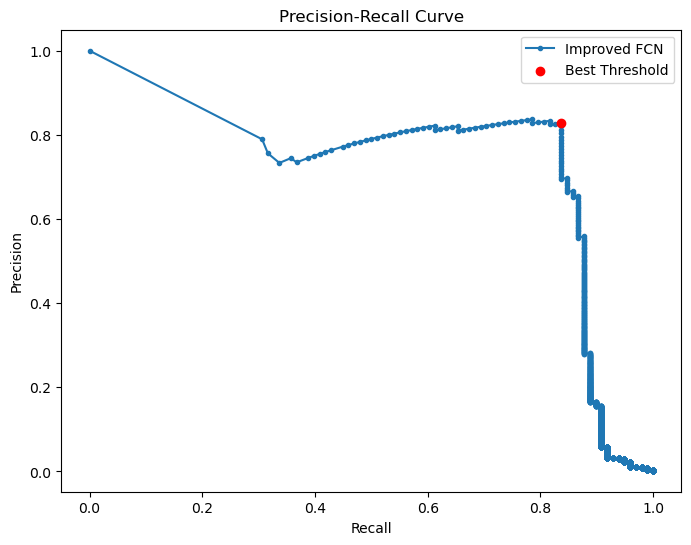

In [21]:
# --- 1. Get Probabilities from Best Model ---
model_improved.eval()
y_true = []
y_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        logits = model_improved(inputs)
        probs = torch.sigmoid(logits)
        y_true.extend(labels.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# --- 2. Threshold Optimization ---
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {f1_scores[best_idx]:.4f}")

# --- 3. Final Evaluation ---
y_pred_opt = (np.array(y_probs) > best_threshold).astype(int)
roc_auc = roc_auc_score(y_true, y_probs)

print(f"\n--- Final Results (Improved + Optimized) ---")
print(f"ROC-AUC: {roc_auc:.4f}")
print(classification_report(y_true, y_pred_opt, target_names=['Legit', 'Fraud']))

# --- 4. Visualization: Precision-Recall Curve ---
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Improved FCN')
plt.scatter(recall[best_idx], precision[best_idx], marker='o', color='red', label='Best Threshold', zorder=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## 6. Final Visualization: Confusion Matrix
**Objective**: Visualize the cost of False Positives.

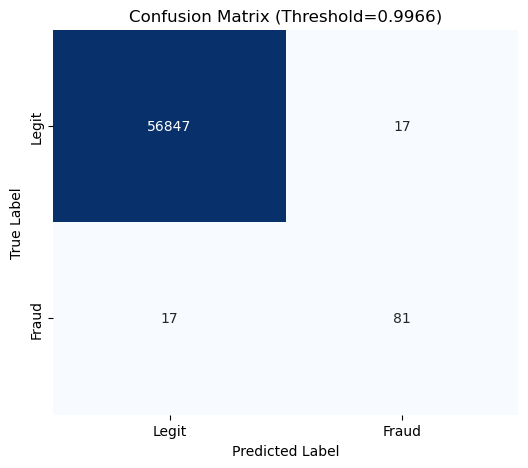

In [22]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    
    # Heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Legit', 'Fraud'], 
                yticklabels=['Legit', 'Fraud'])
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Run for the Optimized Predictions
plot_confusion_matrix(y_true, y_pred_opt, title=f"Confusion Matrix (Threshold={best_threshold:.4f})")